In [272]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Data Preprocessing
Locate files:

C = Cuivre / Copper / Cu
Z = Zinc / Zn
M = Methomyl

In [385]:
#Apply tail filter to final half hour of data
def sigmoid(x):
    """
    Sigmoid function.
    """
    return 1 / (1 + np.exp(-x))

def smooth_tail_to_zero(arr, window_size=30*3):
    """
    Apply sigmoid filtering to the last 'window_size' values of a time series.

    Parameters:
    - time_series: Numpy array.
    - window_size: Number of values to apply the sigmoid filtering (default: 30).

    Returns:
    - Filtered time series.
    """
    # Copy arr to arr_filtered
    arr_filtered = arr.copy()

    # Extract the last 'window_size' values
    tail_values = arr[-window_size:]

    # Generate a reversed sigmoid function with the same length as the tail
    sigmoid_values = sigmoid(np.linspace(6, -6, window_size))

    # Apply reversed sigmoid filtering to the tail
    smoothed_tail = tail_values * sigmoid_values

    # Replace the tail in the original time series with the smoothed values
    arr_filtered[-window_size:] = smoothed_tail

    return arr_filtered


In [386]:
def extract_substances(dataframe):
    # Get the column names from the DataFrame
    columns = dataframe.columns

    # Create a dictionary to store the count of each unique substance
    substance_counts = {}

    # Extract unique substances from the column names and count occurrences
    for column in columns:
        # Split the column name based on the numeric part
        substance = ''.join([i for i in column if not i.isdigit()])
        
        # Update the count in the dictionary
        substance_counts[substance] = substance_counts.get(substance, 0) + 1

    # Convert the dictionary to two lists (substances and counts) and sort them
    unique_substances_list = sorted(list(substance_counts.keys()))
    counts_list = [substance_counts[substance] for substance in unique_substances_list]

    return unique_substances_list,counts_list

In [387]:
def get_fp_data(fpc_object,pcs = 2,gridpoints = np.arange(360)):
    """
    'Inputs'
    fpc_obj - functional data object already in pca form (1-D)
    pcs - number of functional principal components to take into account (int)
    
    'Outputs'
    np.arr - X array (gridpoints)
    np.arr 2D - Y arrays (data points - no. fpcs - 2 by default)
    """
    fpc_grid_points = fpc_object.components_.to_grid(gridpoints).grid_points[0]
    fpc_data_points = [np.zeros_like(fpc_grid_points) for i in range(pcs)]
    fpc_variance_exp = np.array([fpc_object.explained_variance_ratio_[i] for i in range(pcs)])
    for i in range(pcs):
        fpc_data_points[i] = fpc_object.components_.to_grid(gridpoints)[i].data_matrix[0].flatten()
        
    return fpc_grid_points,fpc_data_points,fpc_variance_exp
    

### FPCA for individual species

In [388]:
#define parameters
specie = {'E':'Erpobdella','G':'Gammarus','R':'Radix'}
specie_dim = {'E':'X','G':'Y','R':'Z'}

In [389]:
#locate files and load data for each species
directory = r'D:\VP\ARTICLE2\ArticleData'
data = {s:pd.read_csv(r'{}\{}_{}_m_data.csv'.format(directory,s,specie_dim[s])) for s in specie}

In [390]:
data['E'].head()

,Copper0,Copper1,Copper2,Copper3,Copper4,Copper5,Copper6,Copper7,Methomyl0,Methomyl1,...,Methomyl4,Methomyl5,Methomyl6,Verapamil0,Verapamil1,Verapamil2,Zinc0,Zinc1,Zinc2,Zinc3
0,0.945344,1.178407,0.942724,0.579559,0.914621,0.961204,0.745719,1.050060,0.467611,0.380521,...,0.539370,0.904664,0.361904,0.640712,0.631497,0.773536,0.635086,0.512021,0.862880,0.904256
1,0.938500,1.221824,0.944277,0.584017,0.911131,0.951598,0.748828,1.051829,0.461963,0.378061,...,0.538812,0.900993,0.370543,0.629859,0.627467,0.782709,0.639892,0.516113,0.862510,0.894739
2,0.932024,1.248514,0.942291,0.592446,0.910729,0.945301,0.751730,1.050432,0.452700,0.375472,...,0.538224,0.894976,0.383075,0.617883,0.622113,0.792597,0.642081,0.520889,0.861477,0.884955
3,0.919930,1.247853,0.939164,0.603059,0.913264,0.946802,0.755181,1.051703,0.445602,0.372888,...,0.537319,0.893944,0.398040,0.608372,0.620058,0.797667,0.645558,0.523997,0.862174,0.874373
4,0.913487,1.223459,0.936387,0.621582,0.917755,0.943569,0.765421,1.054773,0.439288,0.370307,...,0.536095,0.893248,0.409270,0.598150,0.618374,0.802557,0.646876,0.525455,0.864088,0.866415


In [391]:
#identify all used substances
substances,counts = extract_substances(data[[*data][0]])
substances,counts

(['Copper', 'Methomyl', 'Verapamil', 'Zinc'], [8, 7, 3, 4])

In [392]:
plot_colors = {'Copper':'#8c564b','Methomyl':'#9467bd','Verapamil':'#d62728','Zinc':'#e377c2'}
custom_palette = [plot_colors[s] for s in plot_colors]
sns.set_palette(custom_palette)
custom_palette

['#8c564b', '#9467bd', '#d62728', '#e377c2']

In [393]:
#Define columns and y values for functional data analysis
cols = data[[*data][0]].columns
y = ['{}'.format(s) for i,s in enumerate(substances) for x in range(counts[i])]
y

['Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Verapamil',
 'Verapamil',
 'Verapamil',
 'Zinc',
 'Zinc',
 'Zinc',
 'Zinc']

### Plot each data curve for each species

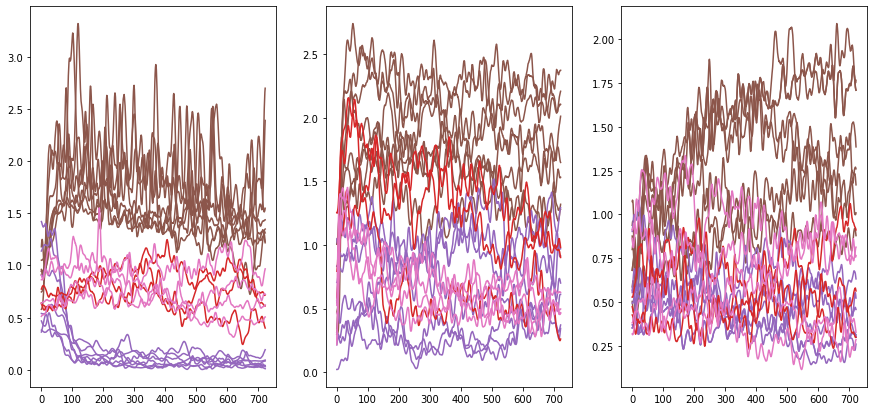

In [394]:
fig,axes = plt.subplots(1,3,figsize=(15,7))
for i,s in enumerate(specie):
    for x,col in enumerate(data[s].columns):
        axes[i].plot(data[s].index,data[s][col].values,color = plot_colors[y[x]])

### Import relevant Data Structures and convert to FD Data Grids and BSplines

In [395]:
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis

In [396]:
#Define timestep for data and remove end data
timestep = 30
full_length = data[[*data][0]].shape[0]
#n_rows = (full_length//timestep)*timestep
n_rows = 360

In [397]:
#Cut dataframe at n_rows
for s in specie:
    data[s] = data[s].iloc[:n_rows]
    
data[s].shape

(360, 22)

In [398]:
data['E'].head()

,Copper0,Copper1,Copper2,Copper3,Copper4,Copper5,Copper6,Copper7,Methomyl0,Methomyl1,...,Methomyl4,Methomyl5,Methomyl6,Verapamil0,Verapamil1,Verapamil2,Zinc0,Zinc1,Zinc2,Zinc3
0,0.945344,1.178407,0.942724,0.579559,0.914621,0.961204,0.745719,1.050060,0.467611,0.380521,...,0.539370,0.904664,0.361904,0.640712,0.631497,0.773536,0.635086,0.512021,0.862880,0.904256
1,0.938500,1.221824,0.944277,0.584017,0.911131,0.951598,0.748828,1.051829,0.461963,0.378061,...,0.538812,0.900993,0.370543,0.629859,0.627467,0.782709,0.639892,0.516113,0.862510,0.894739
2,0.932024,1.248514,0.942291,0.592446,0.910729,0.945301,0.751730,1.050432,0.452700,0.375472,...,0.538224,0.894976,0.383075,0.617883,0.622113,0.792597,0.642081,0.520889,0.861477,0.884955
3,0.919930,1.247853,0.939164,0.603059,0.913264,0.946802,0.755181,1.051703,0.445602,0.372888,...,0.537319,0.893944,0.398040,0.608372,0.620058,0.797667,0.645558,0.523997,0.862174,0.874373
4,0.913487,1.223459,0.936387,0.621582,0.917755,0.943569,0.765421,1.054773,0.439288,0.370307,...,0.536095,0.893248,0.409270,0.598150,0.618374,0.802557,0.646876,0.525455,0.864088,0.866415


In [400]:
#define FDA parameters with uneven knots
domain_range = (0,n_rows)
order = 4

#define knots with uneven spacing
knots = np.hstack((np.array([0,30,60,90,120,150]),np.arange(180,n_rows+90,90)))
#knots = np.hstack((np.array([0,30,60,90,120,150]),np.arange(180,181)))

n_basis = len(knots) + order - 2

bbs = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)
knots

array([  0,  30,  60,  90, 120, 150, 180, 270, 360])

In [401]:
#define grid points and data matrices
grid_points = np.arange(n_rows)
data_matrices = {s:np.transpose(np.array(data[s].iloc[:n_rows])) for s in specie}

#define functional data grids
fds = {s:FDataGrid(data_matrix=data_matrices[s],grid_points=grid_points,) for s in specie}

### Create basis functions

In [402]:
#create basis functions
bss = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)

In [403]:
X_bss = {s:fds[s].to_basis(bss) for s in specie}

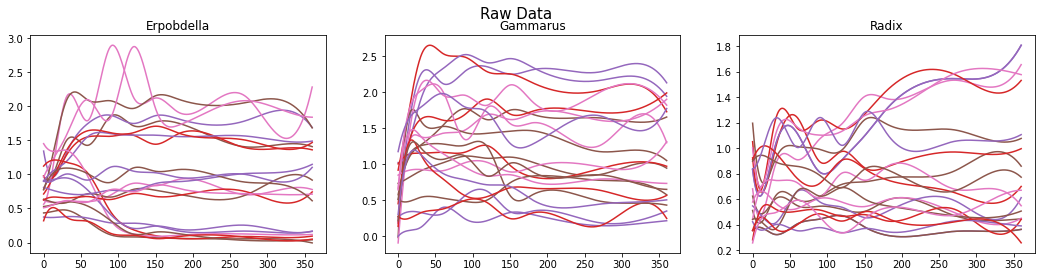

In [404]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Raw Data',fontsize = 15)
for i,s in enumerate(specie): 
    X_bss[s].plot(axes = axe[i])
    axe[i].set_title(specie[s])

In [430]:
test = X_bss['E'].to_grid(grid_points = np.arange(360))

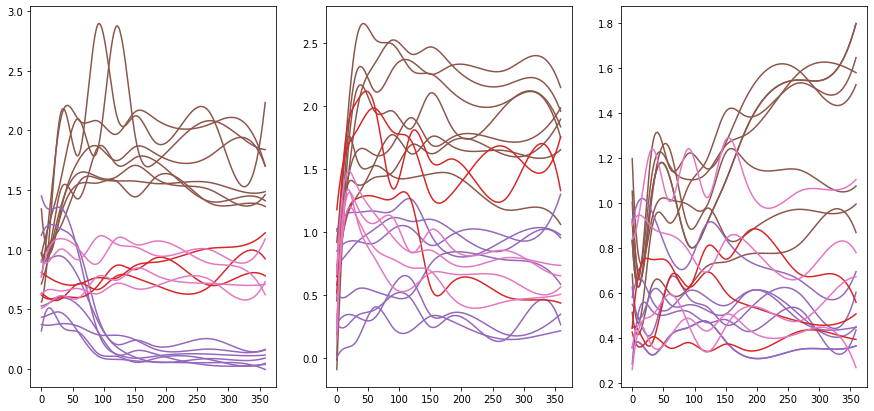

In [429]:
fig,axes = plt.subplots(1,3,figsize=(15,7))
for i,s in enumerate(specie):
    X_grid = X_bss[s].to_grid(grid_points = np.arange(n_rows))
    for x,col in enumerate(data[s].columns):
        axes[i].plot(X_grid.grid_points[0],X_grid.data_matrix[x].flatten(),color = plot_colors[y[x]])

## FPCA

In [405]:
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA

In [406]:
fpcas = {s: FPCA(n_components=2).fit(X_bss[s]) for s in specie}

In [407]:
fpcas['E'].components_

FDataBasis(
    basis=BSplineBasis(domain_range=((0.0, 360.0),), n_basis=11, order=4, knots=(0, 30, 60, 90, 120, 150, 180, 270, 360)),
    coefficients=[[ 0.00680021  0.00551949  0.04177058  0.03754234  0.06244212  0.06184377
       0.0582794   0.05313549  0.06152608  0.05087311  0.05372495]
     [ 0.07024312  0.07858547  0.16906511  0.07528611  0.04746253 -0.02269394
      -0.01318836 -0.03986358  0.01941416 -0.05855791 -0.02819349]],
    dataset_name=None,
    argument_names=(None,),
    coordinate_names=(None,),
    extrapolation=None)

Text(0.5, 1.0, 'Functional Principal Component plot')

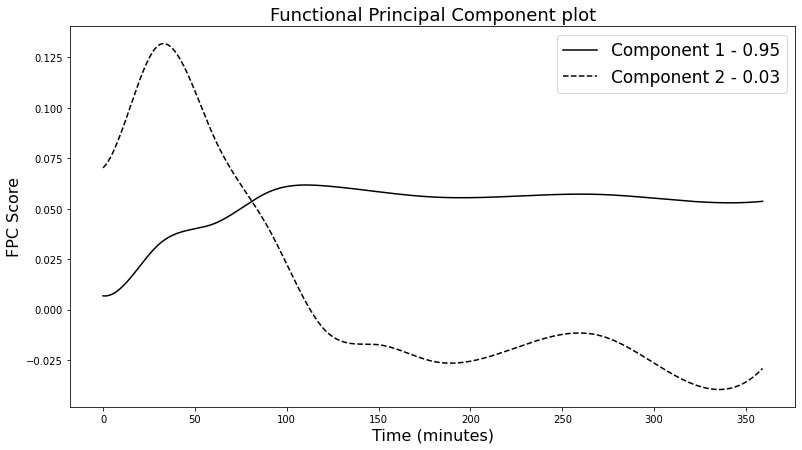

In [408]:
#Convert fpc1 and fpc2 to np.arrays
grid_points,data_points,variances = get_fp_data(fpcas['E'],gridpoints = np.arange(n_rows))

#plot each component
fig,ax = plt.subplots(figsize = (13,7))
ax.plot(grid_points,data_points[0],color = 'black')
ax.plot(grid_points,data_points[1],color = 'black',linestyle = '--')
ax.legend(labels=['Component 1 - {:.2f}'.format(variances[0]),
                  'Component 2 - {:.2f}'.format(variances[1])],
         fontsize = 17)
ax.set_xlabel('Time (minutes)',fontsize = 16)
ax.set_ylabel('FPC Score',fontsize = 16)
ax.set_title('Functional Principal Component plot',fontsize = 18)

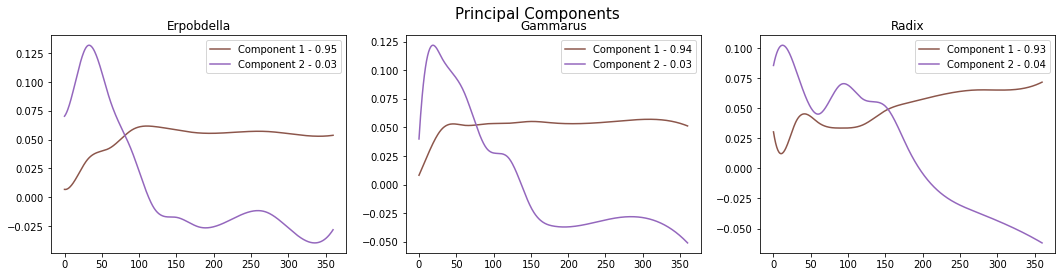

In [409]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Principal Components',fontsize = 15)
for i,s in enumerate(specie):
    fpcas[s].components_.plot(axes = axe[i])
    axe[i].legend(
        labels=['Component 1 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[0]),
                'Component 2 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[1])])
    axe[i].set_title(specie[s])

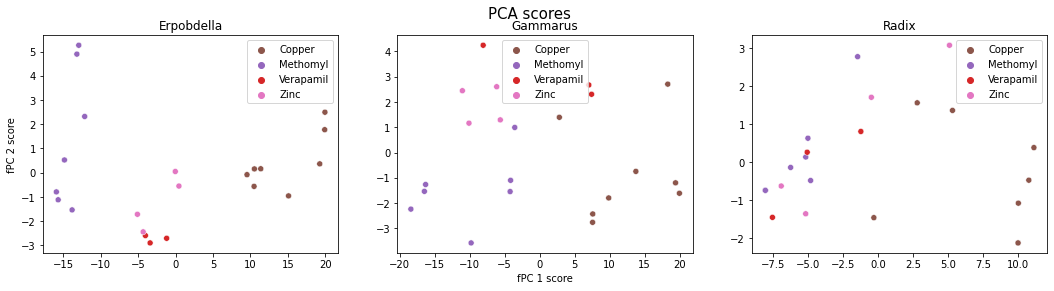

In [410]:
#Show all PCAs as FPCA scores plot
scores = {s:fpcas[s].fit_transform(X_bss[s]) for s in specie}

fig_FPCA,ax_FPCA = plt.subplots(1,3,figsize=(18,4))
fig_FPCA.suptitle('PCA scores',fontsize = 15)

ax_FPCA[1].set_xlabel("fPC 1 score")
ax_FPCA[0].set_ylabel("fPC 2 score")

for i,s in enumerate(specie):
    sns.scatterplot(x=scores[s][:, 0], y=scores[s][:, 1],hue = y,ax = ax_FPCA[i])
    ax_FPCA[i].set_title(specie[s])  

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

## MultiVector FDA

Whilst this is possible to create multidimensional Vector grids, their combination has not yet been achieved.

In [411]:
from skfda.representation.basis import VectorValuedBasis

In [412]:
n_rows

360

In [413]:
data_vector_matrix = np.transpose(np.array([np.array(data[s].iloc[:n_rows]) for s in specie]))
vector_fd = FDataGrid(data_matrix=data_vector_matrix,grid_points=grid_points,)

In [414]:
vector_bss = VectorValuedBasis([bss for i in range(3)])
vector_bss = vector_fd.to_basis(vector_bss)

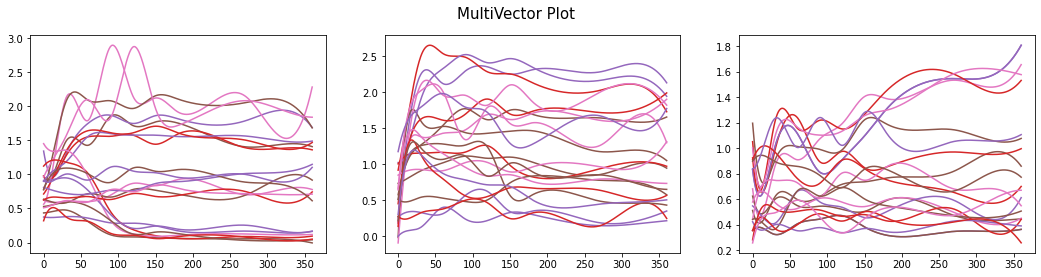

In [415]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector Plot',fontsize = 15)
vector_bss.plot(axes = axe)
plt.show()

### What appears strange here is there is not exactly the same PCA for each domain 

Perhaps there is some kind of normalisation

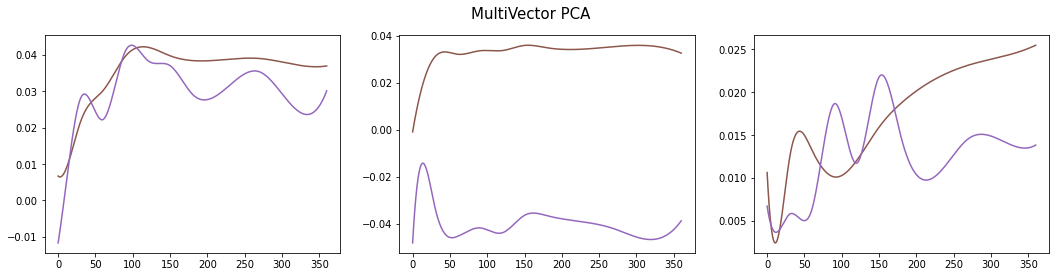

In [416]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector PCA',fontsize = 15)
vector_fpca = FPCA(n_components=2).fit(vector_bss)
vector_fpca.components_.plot(axes = axe)
plt.show()

In [417]:
### Failed PCA plot attempt
scores = vector_fpca.fit_transform(vector_bss)
scores

array([[ 12.56819769,   0.79067338],
       [ 26.63062892,  -4.32234267],
       [ 19.15127166,  -7.87094487],
       [ 22.05213789,   8.74266665],
       [ 17.36035278,  10.95096813],
       [ 23.08953988,  -6.61337362],
       [ 17.4134213 ,   1.29549213],
       [ 25.78238467,   3.3970392 ],
       [-15.39813396,  -7.36778784],
       [-23.98930925,   4.12637387],
       [-11.87349734,  -5.21170228],
       [-13.32158348,  -5.41077052],
       [-19.21629717,  -2.94690533],
       [-20.3593705 ,   4.26856205],
       [-23.43280025,   1.87938142],
       [  1.67500633,  -7.788132  ],
       [ -9.68039132,   2.3929182 ],
       [  1.24584065,  -8.5967294 ],
       [-12.31162639,   3.16696688],
       [ -8.66616477,   0.76023396],
       [ -3.76651087,   4.26714491],
       [ -4.95309648,  10.09026774]])

In [418]:
scores_fp1 = scores[:,0]
scores_fp2 = scores[:,1]
scores_fp1

array([ 12.56819769,  26.63062892,  19.15127166,  22.05213789,
        17.36035278,  23.08953988,  17.4134213 ,  25.78238467,
       -15.39813396, -23.98930925, -11.87349734, -13.32158348,
       -19.21629717, -20.3593705 , -23.43280025,   1.67500633,
        -9.68039132,   1.24584065, -12.31162639,  -8.66616477,
        -3.76651087,  -4.95309648])

In [419]:
positive_scores = scores[scores>0]
negative_scores = -scores[scores<0]

log_positive_scores = np.log(1+positive_scores)
log_negative_scores = np.log(1+negative_scores)

log_scores = np.empty_like(scores)
log_scores[scores>0] = log_positive_scores
log_scores[scores<0] = -log_negative_scores

log_scores

array([[ 2.60772865,  0.58259174],
       [ 3.3189249 , -1.67191356],
       [ 3.0032674 , -2.18278131],
       [ 3.13775852,  2.27651486],
       [ 2.9101936 ,  2.48081229],
       [ 3.18177772, -2.02990639],
       [ 2.91307982,  0.83094726],
       [ 3.28774438,  1.4809314 ],
       [-2.79716755, -2.12438955],
       [-3.2184481 ,  1.63439856],
       [-2.55517073, -1.82643498],
       [-2.66176773, -1.85797947],
       [-3.00648907, -1.37293181],
       [-3.06149054,  1.66175747],
       [-3.1959265 ,  1.05757549],
       [ 0.98395175, -2.17340218],
       [-2.36840947,  1.22169038],
       [ 0.80907991, -2.26142235],
       [-2.58863782,  1.4271884 ],
       [-2.26863162,  0.56544673],
       [-1.56161456,  1.66148845],
       [-1.7839115 ,  2.40606794]])

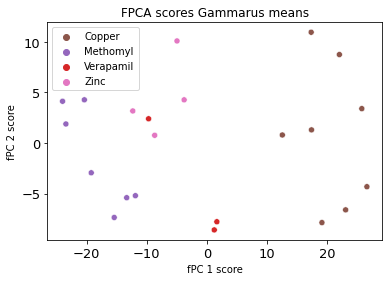

In [420]:
fig_vector_FPCA,ax_vector_FPCA = plt.subplots(figsize=(6, 4))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1],hue = y,ax = ax_vector_FPCA)
ax_vector_FPCA.set_xlabel("fPC 1 score")
ax_vector_FPCA.set_ylabel("fPC 2 score")
ax_vector_FPCA.set_title("FPCA scores Gammarus means")

ax_vector_FPCA.tick_params(labelsize = 13)
plt.show()

# Clustering

**Clustering methods should be fed the smoothed data not the basis data - it must be loaded in**

In [310]:
from skfda.exploratory.visualization.clustering import (
    ClusterMembershipLinesPlot,
    ClusterMembershipPlot,
    ClusterPlot
)
from skfda.ml.clustering import FuzzyCMeans,KMeans

## Single basis clusters

In [311]:
#Clustering unsupervised (except no. clusters)
n_clusters = 4
seed = 0

kmeans = {s:KMeans(n_clusters = n_clusters, random_state = seed).fit(X_bss[s].to_grid()) for s in specie}
for s in specie:
    print('Kmeans prediction: {}'.format(specie[s]))
    print(kmeans[s].predict(X_bss[s].to_grid()))

Kmeans prediction: Erpobdella
[0 0 0 0 0 0 0 0 2 2 1 1 2 1 2 3 3 3 3 3 3 3]
Kmeans prediction: Gammarus
[1 1 1 1 1 1 1 1 0 2 0 0 0 3 2 1 0 1 0 0 0 0]
Kmeans prediction: Radix
[0 1 2 1 2 1 1 1 3 3 0 3 3 3 3 0 3 3 3 3 0 2]


In [312]:
vector_kmean = KMeans(n_clusters = 4, random_state = seed).fit(vector_bss.to_grid())
vector_kmean.predict(vector_bss.to_grid())

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 2, 1, 3, 1, 3, 3, 3, 3])